### 1. Install packages

In [1]:
# if (!requireNamespace("BiocManager", quietly = TRUE))
#     install.packages("BiocManager")
# BiocManager::install("dada2")
# install.packages("magrittr")
# install.packages("stringr")
# install.packages("data.table")
# install.packages("qualpalr")
# install.packages("seqinr")

### 2. Load R libraries for DADA2 processing

In [2]:
library(dada2, verbose = FALSE)
library(stringr, verbose = FALSE)
library(data.table, verbose = FALSE)
library(qualpalr, verbose = FALSE)
library(ShortRead, verbose = FALSE)
library(Biostrings, verbose = FALSE)
library(seqinr, verbose = FALSE)

Loading required package: Rcpp

Warning message:
“package ‘Rcpp’ was built under R version 4.1.3”
Warning message:
“package ‘stringr’ was built under R version 4.1.3”
Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: BiocParallel

Loading required package: Biostrings

Loading required package: S4Vectors

Loading required package: stats4


Attaching package: ‘S4Vectors’


The following objects are masked from

### 3. Set up file path to raw data

In [3]:
rawpath <- "raw"
wdpath <- "/home/allie/long_oral_microbiome/01-read_processing/" # change to where git repository was cloned
fnFs <- sort(list.files(rawpath, pattern="_R1_001.fastq.gz", full.names=T))
fnRs <- sort(list.files(rawpath, pattern="_R2_001.fastq.gz", full.names=T))
sample.names <- sapply(strsplit(basename(fnFs), "_"), `[`, 1)
head(sample.names, 50)
paste("Number of input samples: ", length(sample.names))

[1] "DM00001V1PQ"      "DM00001V2PQ16"    "DM00001V3PQ46"    "DM00002V1PQ"     
 [5] "DM00003V3PQ16"    "DM00003V3PQ55"    "DM00004V1PQ55"    "DM00004V1PQ65"   
 [9] "DM00004V3PQ16"    "DM00005V1PQ36-1"  "DM00005V1PQ46-2"  "DM00005V2PQ16"   
[13] "DM00005V3PQ16"    "DM00006V1PQ1"     "DM00006V2PQ16"    "DM00006V3PQ36"   
[17] "DM00007V1PQ1"     "DM00007V2PQ55"    "DM00007V3PQ16"    "DM00008V1PQ16-2" 
[21] "DM00008V1PQ26-1"  "DM00008V2PQ16"    "DM00008V3PQ16"    "DM00009V1PQ55"   
[25] "DM00009V1PQ65"    "DM00009V3PQ55"    "DM00010V1PQ54"    "DM00010V1PQ64-65"
[29] "DM00010V3PQ55"    "DM00011V1PQ55-1"  "DM00011V2PQ55"    "DM00011V3PQ26"   
[33] "DM00012V1PQ1"     "DM00012V2PQ16"    "DM00012V3PQ16"    "DM00013V1PQ65-3" 
[37] "DM00013V1PQ73-1"  "DM00013V1PQ83-2"  "DM00013V2PQ53"    "DM00013V2PQ64"   
[41] "DM00013V3PQ16"    "DM00013V3PQ46"    "DM00013V3PQ73"    "DM00014V1PQ3"    
[45] "DM00014V1PQ64-2"  "DM00014V1PQ84-1"  "DM00014V2PQ64"    "DM00014V2PQ72"   
[49] "DM00014V3PQ54"    "DM00014V3PQ75"

[1] "Number of input samples:  2251"

### 4. Generate quality plots

Warning message:
“The `<scale>` argument of `guides()` cannot be `FALSE`. Use "none" instead as of ggplot2 3.3.4.
ℹ The deprecated feature was likely used in the dada2 package.
  Please report the issue at <https://github.com/benjjneb/dada2/issues>.”


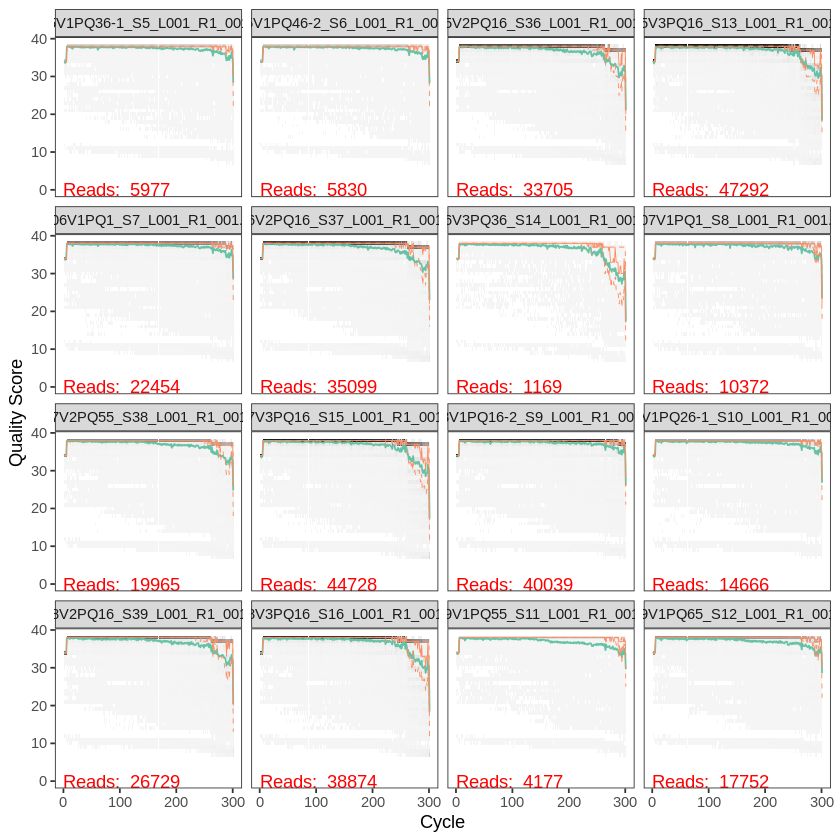

png 
  2

png 
  2

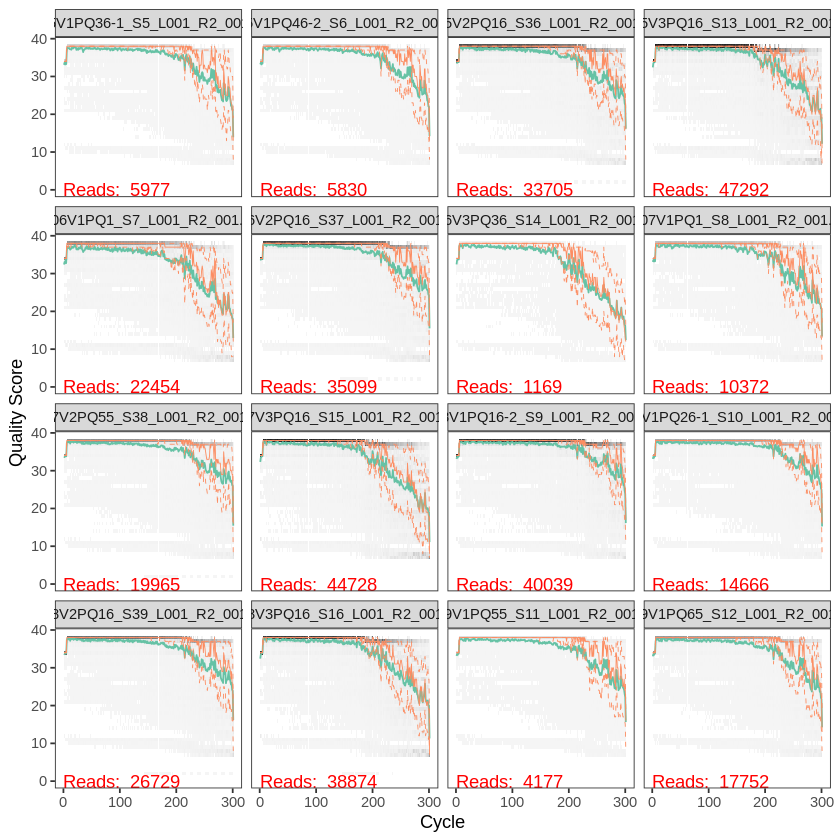

In [4]:
system("mkdir img") # ignore warning
fwdqual <- plotQualityProfile(fnFs[10:25])
revqual <- plotQualityProfile(fnRs[10:25])
fwdqual
revqual

pdf(paste(wdpath, "img/", "forward_quality_plot.pdf", sep=""))
fwdqual
dev.off()
pdf(paste(wdpath, "img/", "reverse_quality_plot.pdf", sep=""))
revqual
dev.off()

### 5. Preliminary read filter (removes any reads with Ns)

In [5]:
fnFs.filtN <- file.path(rawpath, "filtN", basename(fnFs)) # Put N-filtered files in filtN/ subdirectory
fnRs.filtN <- file.path(rawpath, "filtN", basename(fnRs))
filterAndTrim(fnFs, fnFs.filtN, fnRs, fnRs.filtN, maxN = 0, multithread = TRUE, compress = TRUE)

### 6. Cutadapt remove primer sequences and any adapter contamination

In [6]:
cutadapt <- as.character(system("which cutadapt", intern=T))
system("cutadapt --version")
path.cut <- file.path(rawpath, "cutadapt")
if(!dir.exists(path.cut)) dir.create(path.cut)
fnFs.cut <- file.path(path.cut, basename(fnFs))
fnRs.cut <- file.path(path.cut, basename(fnRs))
FWD.RC <- dada2:::rc("MAYGARAARMGNATGYTNCARGA")
REV.RC <- dada2:::rc("GMCATYTGRTCNCCRTCRAA")
# Trim FWD and the reverse-complement of REV off of R1 (forward reads)
R1.flags <- paste("-g", "MAYGARAARMGNATGYTNCARGA", "-a", REV.RC) 
# Trim REV and the reverse-complement of FWD off of R2 (reverse reads)
R2.flags <- paste("-G", "GMCATYTGRTCNCCRTCRAA", "-A", FWD.RC) 
for(i in seq_along(fnFs)) {
  system2(cutadapt, args = c("--cores=0", R1.flags, R2.flags, "-n", 2,"-o", fnFs.cut[i], "-p", fnRs.cut[i], fnFs.filtN[i], fnRs.filtN[i]))
}
cutFs <- sort(list.files(path.cut, pattern = "R1", full.names = TRUE))
cutRs <- sort(list.files(path.cut, pattern = "R2", full.names = TRUE))

### 7. Quality filter and trim reads

In [7]:
filtFs <- file.path(path.cut, "filtered", basename(cutFs))
filtRs <- file.path(path.cut, "filtered", basename(cutRs))
out <- filterAndTrim(cutFs, filtFs, cutRs, filtRs, trimRight=25, maxN=c(0,0), maxEE=c(4,6), rm.phix=TRUE, matchIDs=TRUE, compress=TRUE, multithread=TRUE)
retained <- as.data.frame(out)
retained$percentage_retained <- retained$reads.out/retained$reads.in*100
retained

Creating output directory: raw/cutadapt/filtered



,reads.in,reads.out,percentage_retained
,<dbl>,<dbl>,<dbl>
DM00001V1PQ_S1_L001_R1_001.fastq.gz,15200,14784,97.26316
DM00001V2PQ16_S31_L001_R1_001.fastq.gz,45005,43107,95.78269
DM00001V3PQ46_S9_L001_R1_001.fastq.gz,1141,1068,93.60210
DM00002V1PQ_S2_L001_R1_001.fastq.gz,5387,5247,97.40115
DM00003V3PQ16_S10_L001_R1_001.fastq.gz,31773,30528,96.08158
DM00003V3PQ55_S11_L001_R1_001.fastq.gz,19333,18559,95.99648
DM00004V1PQ55_S3_L001_R1_001.fastq.gz,925,894,96.64865
DM00004V1PQ65_S4_L001_R1_001.fastq.gz,20,19,95.00000
DM00004V3PQ16_S12_L001_R1_001.fastq.gz,24775,23168,93.51362


### 8. Learn error rates

109215733 total bases in 441335 reads from 12 samples will be used for learning the error rates.
100872725 total bases in 402476 reads from 14 samples will be used for learning the error rates.


Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


png 
  2

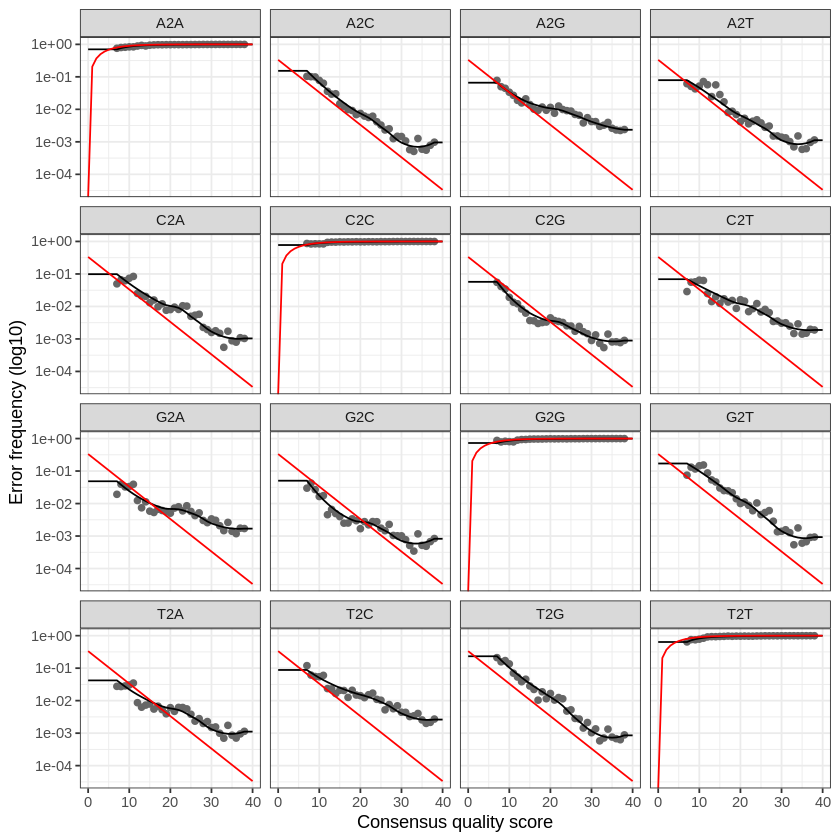

In [8]:
set.seed(12349)
errF <- learnErrors(filtFs, multithread=T, random=T)
errR <- learnErrors(filtRs, multithread=T, random=T)
err.f.plt <- plotErrors(errF, nominalQ=TRUE) 
err.f.plt
pdf(paste(wdpath, "img/", "error_plot.pdf", sep=""))
err.f.plt
dev.off()

### 9. Dereplication

In [9]:
derepFs <- derepFastq(filtFs, verbose=TRUE)
derepRs <- derepFastq(filtRs, verbose=TRUE)
sample.names <- sapply(strsplit(basename(filtFs), "_"), `[`, 1)
names(derepFs) <- sample.names
names(derepRs) <- sample.names

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00001V1PQ_S1_L001_R1_001.fastq.gz

Encountered 4017 unique sequences from 14784 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00001V2PQ16_S31_L001_R1_001.fastq.gz

Encountered 8281 unique sequences from 43107 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00001V3PQ46_S9_L001_R1_001.fastq.gz

Encountered 475 unique sequences from 1068 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00002V1PQ_S2_L001_R1_001.fastq.gz

Encountered 1636 unique sequences from 5247 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00003V3PQ16_S10_L001_R1_001.fastq.gz

Encountered 8231 unique sequences from 30528 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00003V3PQ55_S11_L001_R1_001.fastq.gz

Encountered 4726 uniqu

Encountered 4684 unique sequences from 18867 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00014V2PQ72_S49_L001_R1_001.fastq.gz

Encountered 5045 unique sequences from 18412 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00014V3PQ54_S25_L001_R1_001.fastq.gz

Encountered 10078 unique sequences from 32501 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00014V3PQ75_S26_L001_R1_001.fastq.gz

Encountered 12921 unique sequences from 46937 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00014V3PQ85_S27_L001_R1_001.fastq.gz

Encountered 4232 unique sequences from 23651 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00015V1PQ_S23_L001_R1_001.fastq.gz

Encountered 7040 unique sequences from 33030 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cu

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00023V2PQ16_S60_L001_R1_001.fastq.gz

Encountered 9175 unique sequences from 33010 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00023V3PQ16_S38_L001_R1_001.fastq.gz

Encountered 12797 unique sequences from 46441 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00024V1PQ16-1_S47_L001_R1_001.fastq.gz

Encountered 2408 unique sequences from 9404 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00024V1PQ41-1_S48_L001_R1_001.fastq.gz

Encountered 6193 unique sequences from 33536 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00024V1PQ46-1_S49_L001_R1_001.fastq.gz

Encountered 411 unique sequences from 1116 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00024V1PQ54-1_S50_L001_R1_001.fastq.gz

Encoun

Encountered 14557 unique sequences from 55274 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00032V3PQ26_S50_L001_R1_001.fastq.gz

Encountered 11256 unique sequences from 39928 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00032V3PQ36_S51_L001_R1_001.fastq.gz

Encountered 419 unique sequences from 1246 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00033V1PQ26_S73_L001_R1_001.fastq.gz

Encountered 12093 unique sequences from 39504 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00033V1PQ65_S74_L001_R1_001.fastq.gz

Encountered 16910 unique sequences from 62093 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00033V2PQ36_S72_L001_R1_001.fastq.gz

Encountered 9454 unique sequences from 48913 total sequences read.

Dereplicating sequence entries in Fastq file: raw/

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00040V3PQ16_S61_L001_R1_001.fastq.gz

Encountered 13288 unique sequences from 44277 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00041V1PQ26-1_S98_L001_R1_001.fastq.gz

Encountered 18579 unique sequences from 64931 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00041V1PQ36-1_S99_L001_R1_001.fastq.gz

Encountered 16218 unique sequences from 57627 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00041V2PQ55_S82_L001_R1_001.fastq.gz

Encountered 14711 unique sequences from 57337 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00041V3PQ26_S62_L001_R1_001.fastq.gz

Encountered 12306 unique sequences from 43684 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00042V1PQ55-65-1_S100_L001_R1_001.fastq.g

Encountered 4587 unique sequences from 14616 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00049V1PQ11_S120_L001_R1_001.fastq.gz

Encountered 11813 unique sequences from 44876 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00049V1PQ41_S121_L001_R1_001.fastq.gz

Encountered 10883 unique sequences from 35809 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00049V1PQ55_S122_L001_R1_001.fastq.gz

Encountered 13517 unique sequences from 47883 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00049V1PQ65_S123_L001_R1_001.fastq.gz

Encountered 7991 unique sequences from 31459 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00049V2PQ16_S95_L001_R1_001.fastq.gz

Encountered 18798 unique sequences from 77592 total sequences read.

Dereplicating sequence entries in Fastq file

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00057V1PQ16_S144_L001_R1_001.fastq.gz

Encountered 11708 unique sequences from 50691 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00057V1PQ75_S145_L001_R1_001.fastq.gz

Encountered 15176 unique sequences from 56011 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00057V2PQ26_S106_L001_R1_001.fastq.gz

Encountered 15205 unique sequences from 52900 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00057V3PQ16_S87_L001_R1_001.fastq.gz

Encountered 1389 unique sequences from 3607 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00058V1PQ36_S146_L001_R1_001.fastq.gz

Encountered 14572 unique sequences from 60648 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00058V1PQ74_S147_L001_R1_001.fastq.gz

Enco

Encountered 7204 unique sequences from 21307 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00066V1PQ26_S168_L001_R1_001.fastq.gz

Encountered 9133 unique sequences from 31522 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00066V2PQ16_S118_L001_R1_001.fastq.gz

Encountered 13425 unique sequences from 47808 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00066V3PQ16_S99_L001_R1_001.fastq.gz

Encountered 6217 unique sequences from 20990 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00067V1PQ11_S169_L001_R1_001.fastq.gz

Encountered 7111 unique sequences from 27306 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00067V1PQ41_S170_L001_R1_001.fastq.gz

Encountered 13215 unique sequences from 45633 total sequences read.

Dereplicating sequence entries in Fastq file: 

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00074V3PQ64_S109_L001_R1_001.fastq.gz

Encountered 1896 unique sequences from 8918 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00075V1PQ41_S49_L001_R1_001.fastq.gz

Encountered 5476 unique sequences from 15358 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00075V1PQ64_S50_L001_R1_001.fastq.gz

Encountered 8981 unique sequences from 24511 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00075V1PQ85_S51_L001_R1_001.fastq.gz

Encountered 5892 unique sequences from 14036 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00075V2PQ16_S132_L001_R1_001.fastq.gz

Encountered 11108 unique sequences from 43730 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00075V3PQ65_S110_L001_R1_001.fastq.gz

Encounter

Encountered 12369 unique sequences from 30281 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00086V1PQ55_S77_L001_R1_001.fastq.gz

Encountered 13980 unique sequences from 35973 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00086V1PQ75_S78_L001_R1_001.fastq.gz

Encountered 8123 unique sequences from 20528 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00086V3PQ16_S121_L001_R1_001.fastq.gz

Encountered 9462 unique sequences from 37279 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00086V3PQ26_S122_L001_R1_001.fastq.gz

Encountered 5154 unique sequences from 19041 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00086V3PQ55_S123_L001_R1_001.fastq.gz

Encountered 4783 unique sequences from 16321 total sequences read.

Dereplicating sequence entries in Fastq file: r

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00096V1PQ16_S101_L001_R1_001.fastq.gz

Encountered 14105 unique sequences from 34722 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00096V1PQ26_S102_L001_R1_001.fastq.gz

Encountered 13391 unique sequences from 36795 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00096V1PQ36_S103_L001_R1_001.fastq.gz

Encountered 12676 unique sequences from 30905 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00096V3PQ55_S135_L001_R1_001.fastq.gz

Encountered 6926 unique sequences from 21310 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00097V1PQ16_S104_L001_R1_001.fastq.gz

Encountered 15999 unique sequences from 39559 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00097V1PQ26_S105_L001_R1_001.fastq.gz

En

Encountered 9769 unique sequences from 24427 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00106V1PQ83_S128_L001_R1_001.fastq.gz

Encountered 15215 unique sequences from 39429 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00106V1PQ85_S129_L001_R1_001.fastq.gz

Encountered 11690 unique sequences from 33621 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00106V2PQ16_S166_L001_R1_001.fastq.gz

Encountered 13317 unique sequences from 51853 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00106V2PQ85_S167_L001_R1_001.fastq.gz

Encountered 10218 unique sequences from 32337 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00106V3PQ16_S146_L001_R1_001.fastq.gz

Encountered 1709 unique sequences from 4900 total sequences read.

Dereplicating sequence entries in Fastq file

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00116V3PQ74_S157_L001_R1_001.fastq.gz

Encountered 1619 unique sequences from 6263 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00117V1PQ16_S152_L001_R1_001.fastq.gz

Encountered 17530 unique sequences from 55057 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00117V2PQ16_S179_L001_R1_001.fastq.gz

Encountered 12033 unique sequences from 48312 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00117V3PQ16_S158_L001_R1_001.fastq.gz

Encountered 10714 unique sequences from 47381 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00118V1PQ16_S153_L001_R1_001.fastq.gz

Encountered 17401 unique sequences from 43209 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00118V1PQ26_S154_L001_R1_001.fastq.gz

Enc

Encountered 7592 unique sequences from 31411 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00129V2PQ65_S63_L001_R1_001.fastq.gz

Encountered 3618 unique sequences from 14765 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00129V3PQ16_S171_L001_R1_001.fastq.gz

Encountered 9060 unique sequences from 30955 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00129V3PQ65_S172_L001_R1_001.fastq.gz

Encountered 11763 unique sequences from 46834 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00130V1PQ54_S172_L001_R1_001.fastq.gz

Encountered 9099 unique sequences from 30680 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00130V2PQ55_S86_L001_R1_001.fastq.gz

Encountered 13025 unique sequences from 50897 total sequences read.

Dereplicating sequence entries in Fastq file: r

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00143V3PQ16_S188_L001_R1_001.fastq.gz

Encountered 12545 unique sequences from 41231 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00144V1PQ16_S187_L001_R1_001.fastq.gz

Encountered 21509 unique sequences from 57667 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00144V2PQ16_S6_L001_R1_001.fastq.gz

Encountered 8756 unique sequences from 31900 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00144V3PQ16_S189_L001_R1_001.fastq.gz

Encountered 12412 unique sequences from 42410 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00145V1PQ16_S188_L001_R1_001.fastq.gz

Encountered 16840 unique sequences from 47904 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00145V2PQ16_S7_L001_R1_001.fastq.gz

Encoun

Encountered 13733 unique sequences from 52778 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00157V1PQ16_S18_L001_R1_001.fastq.gz

Encountered 2516 unique sequences from 6535 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00157V2PQ16_S19_L001_R1_001.fastq.gz

Encountered 7037 unique sequences from 23645 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00157V3PQ16_S15_L001_R1_001.fastq.gz

Encountered 18278 unique sequences from 78344 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00158V1PQ61_S19_L001_R1_001.fastq.gz

Encountered 1986 unique sequences from 5240 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00158V2PQ31_S20_L001_R1_001.fastq.gz

Encountered 3691 unique sequences from 12066 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cu

Encountered 10743 unique sequences from 44338 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00169V3PQ55_S31_L001_R1_001.fastq.gz

Encountered 12485 unique sequences from 52635 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00169V3PQ65_S32_L001_R1_001.fastq.gz

Encountered 10994 unique sequences from 45461 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00170V1PQ65_S36_L001_R1_001.fastq.gz

Encountered 974 unique sequences from 2533 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00170V2PQ55_S37_L001_R1_001.fastq.gz

Encountered 6027 unique sequences from 21212 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00170V3PQ55_S33_L001_R1_001.fastq.gz

Encountered 6592 unique sequences from 28606 total sequences read.

Dereplicating sequence entries in Fastq file: raw/c

Encountered 5220 unique sequences from 18538 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00184V3PQ16_S47_L001_R1_001.fastq.gz

Encountered 11287 unique sequences from 44013 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00184V3PQ85_S49_L001_R1_001.fastq.gz

Encountered 10825 unique sequences from 38767 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00185V1PQ75_S53_L001_R1_001.fastq.gz

Encountered 1596 unique sequences from 4599 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00185V1PQ82_S54_L001_R1_001.fastq.gz

Encountered 2575 unique sequences from 8686 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00185V2PQ61_S53_L001_R1_001.fastq.gz

Encountered 9838 unique sequences from 37061 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cu

Encountered 13131 unique sequences from 50697 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00197V3PQ26_S65_L001_R1_001.fastq.gz

Encountered 13361 unique sequences from 44842 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00198V1PQ16_S71_L001_R1_001.fastq.gz

Encountered 2291 unique sequences from 6398 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00198V2PQ16_S73_L001_R1_001.fastq.gz

Encountered 9119 unique sequences from 34223 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00198V3PQ16_S66_L001_R1_001.fastq.gz

Encountered 15112 unique sequences from 56957 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00199V1PQ65_S72_L001_R1_001.fastq.gz

Encountered 3125 unique sequences from 8386 total sequences read.

Dereplicating sequence entries in Fastq file: raw/c

Encountered 8858 unique sequences from 33731 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00210V3PQ16_S81_L001_R1_001.fastq.gz

Encountered 13228 unique sequences from 57658 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00211V1PQ16-55_S89_L001_R1_001.fastq.gz

Encountered 3207 unique sequences from 9656 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00211V2PQ16_S88_L001_R1_001.fastq.gz

Encountered 8582 unique sequences from 31889 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00211V3PQ16_S82_L001_R1_001.fastq.gz

Encountered 11540 unique sequences from 45816 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00212V1PQ55_S90_L001_R1_001.fastq.gz

Encountered 3129 unique sequences from 9870 total sequences read.

Dereplicating sequence entries in Fastq file: raw

Encountered 5794 unique sequences from 18532 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00224V3PQ16_S95_L001_R1_001.fastq.gz

Encountered 13884 unique sequences from 57680 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00224V3PQ84_S97_L001_R1_001.fastq.gz

Encountered 3632 unique sequences from 11532 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00225V1PQ31_S111_L001_R1_001.fastq.gz

Encountered 2856 unique sequences from 8340 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00225V2PQ26_S33_L001_R1_001.fastq.gz

Encountered 4762 unique sequences from 14634 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00225V3PQ26-65_S98_L001_R1_001.fastq.gz

Encountered 6806 unique sequences from 26479 total sequences read.

Dereplicating sequence entries in Fastq file: ra

Encountered 10950 unique sequences from 42737 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00237V1PQ75_S129_L001_R1_001.fastq.gz

Encountered 606 unique sequences from 1476 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00237V2PQ65_S98_L001_R1_001.fastq.gz

Encountered 3909 unique sequences from 13534 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00237V3PQ55_S113_L001_R1_001.fastq.gz

Encountered 417 unique sequences from 1612 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00238V1PQ55_S130_L001_R1_001.fastq.gz

Encountered 1528 unique sequences from 4962 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00238V3PQ55_S114_L001_R1_001.fastq.gz

Encountered 4076 unique sequences from 15807 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cu

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00252V1PQ55_S148_L001_R1_001.fastq.gz

Encountered 2803 unique sequences from 7983 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00252V2PQ55_S3_L001_R1_001.fastq.gz

Encountered 3479 unique sequences from 11918 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00252V3PQ55_S133_L001_R1_001.fastq.gz

Encountered 11890 unique sequences from 45738 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00253V1PQ16_S149_L001_R1_001.fastq.gz

Encountered 3199 unique sequences from 9059 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00253V2PQ17_S4_L001_R1_001.fastq.gz

Encountered 11719 unique sequences from 47530 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00254V1PQ55_S150_L001_R1_001.fastq.gz

Encountere

Encountered 8170 unique sequences from 31222 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00261V2PQ64_S2_L001_R1_001.fastq.gz

Encountered 8056 unique sequences from 30165 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00261V3PQ16_S148_L001_R1_001.fastq.gz

Encountered 12388 unique sequences from 50903 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00262V1PQ65_S166_L001_R1_001.fastq.gz

Encountered 2686 unique sequences from 7985 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00262V2PQ55_S3_L001_R1_001.fastq.gz

Encountered 9546 unique sequences from 36815 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00262V3PQ55_S149_L001_R1_001.fastq.gz

Encountered 12088 unique sequences from 49344 total sequences read.

Dereplicating sequence entries in Fastq file: raw/

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00273V1PQ16_S180_L001_R1_001.fastq.gz

Encountered 3747 unique sequences from 11063 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00273V2PQ46_S100_L001_R1_001.fastq.gz

Encountered 1033 unique sequences from 2466 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00273V3PQ16_S164_L001_R1_001.fastq.gz

Encountered 17071 unique sequences from 53858 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00274V1PQ16_S181_L001_R1_001.fastq.gz

Encountered 3351 unique sequences from 10220 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00274V1PQ26_S182_L001_R1_001.fastq.gz

Encountered 3610 unique sequences from 10989 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00274V1PQ65_S183_L001_R1_001.fastq.gz

Encoun

Encountered 12156 unique sequences from 28547 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00282V2PQ65_S35_L001_R1_001.fastq.gz

Encountered 12645 unique sequences from 44032 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00282V3PQ65_S179_L001_R1_001.fastq.gz

Encountered 13483 unique sequences from 54863 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00283V1PQ55_S7_L001_R1_001.fastq.gz

Encountered 14170 unique sequences from 37638 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00283V2PQ55_S36_L001_R1_001.fastq.gz

Encountered 7830 unique sequences from 25801 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00283V3PQ65_S180_L001_R1_001.fastq.gz

Encountered 10962 unique sequences from 39794 total sequences read.

Dereplicating sequence entries in Fastq file: 

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00296V2PQ65_S50_L001_R1_001.fastq.gz

Encountered 891 unique sequences from 2634 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00296V3PQ16_S5_L001_R1_001.fastq.gz

Encountered 10455 unique sequences from 37657 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00297V1PQ26_S23_L001_R1_001.fastq.gz

Encountered 19254 unique sequences from 48793 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00297V2PQ55-16_S108_L001_R1_001.fastq.gz

Encountered 11103 unique sequences from 38965 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00297V3PQ16_S6_L001_R1_001.fastq.gz

Encountered 10518 unique sequences from 30078 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00298V1PQ54-16_S24_L001_R1_001.fastq.gz

Encou

Encountered 1500 unique sequences from 5968 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00306V1PQ55_S43_L001_R1_001.fastq.gz

Encountered 11861 unique sequences from 30408 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00306V2PQ55_S63_L001_R1_001.fastq.gz

Encountered 10851 unique sequences from 41723 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00306V3PQ55_S19_L001_R1_001.fastq.gz

Encountered 5659 unique sequences from 25924 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00307V1PQ55_S44_L001_R1_001.fastq.gz

Encountered 11142 unique sequences from 26616 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00307V1PQ75_S45_L001_R1_001.fastq.gz

Encountered 10626 unique sequences from 27278 total sequences read.

Dereplicating sequence entries in Fastq file: raw

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00318V2PQ54-55_S77_L001_R1_001.fastq.gz

Encountered 12800 unique sequences from 49104 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00318V3PQ26_S35_L001_R1_001.fastq.gz

Encountered 10062 unique sequences from 35273 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00319V1PQ26_S59_L001_R1_001.fastq.gz

Encountered 11801 unique sequences from 33815 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00319V2PQ16_S78_L001_R1_001.fastq.gz

Encountered 18836 unique sequences from 65860 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00319V3PQ16_S36_L001_R1_001.fastq.gz

Encountered 13192 unique sequences from 43799 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00320V1PQ16_S60_L001_R1_001.fastq.gz

Enco

Encountered 9901 unique sequences from 40090 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00330V1PQ16_S76_L001_R1_001.fastq.gz

Encountered 11689 unique sequences from 28308 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00330V2PQ16_S95_L001_R1_001.fastq.gz

Encountered 18775 unique sequences from 73521 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00330V3PQ26_S49_L001_R1_001.fastq.gz

Encountered 11807 unique sequences from 46056 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00331V1PQ55_S77_L001_R1_001.fastq.gz

Encountered 9209 unique sequences from 24012 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00331V2PQ75_S19_L001_R1_001.fastq.gz

Encountered 8019 unique sequences from 22399 total sequences read.

Dereplicating sequence entries in Fastq file: raw

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00343V1PQ55-16_S91_L001_R1_001.fastq.gz

Encountered 15454 unique sequences from 39111 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00343V2PQ16_S129_L001_R1_001.fastq.gz

Encountered 12366 unique sequences from 36800 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00343V3PQ16_S65_L001_R1_001.fastq.gz

Encountered 8604 unique sequences from 27432 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00344V1PQ55_S92_L001_R1_001.fastq.gz

Encountered 15160 unique sequences from 37158 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00344V2PQ16_S130_L001_R1_001.fastq.gz

Encountered 11710 unique sequences from 42493 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00345V1PQ16_S93_L001_R1_001.fastq.gz

Enc

Encountered 10338 unique sequences from 40103 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00357V1PQ16_S107_L001_R1_001.fastq.gz

Encountered 11609 unique sequences from 30421 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00357V2PQ26_S146_L001_R1_001.fastq.gz

Encountered 15393 unique sequences from 50526 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00357V3PQ16_S82_L001_R1_001.fastq.gz

Encountered 15338 unique sequences from 52676 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00358V1PQ16_S108_L001_R1_001.fastq.gz

Encountered 13285 unique sequences from 34861 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00358V2PQ16_S147_L001_R1_001.fastq.gz

Encountered 10991 unique sequences from 37271 total sequences read.

Dereplicating sequence entries in Fastq fi

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00370V3PQ74_S97_L001_R1_001.fastq.gz

Encountered 707 unique sequences from 2402 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00371V1PQ26_S125_L001_R1_001.fastq.gz

Encountered 10105 unique sequences from 25057 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00371V2PQ16_S161_L001_R1_001.fastq.gz

Encountered 15102 unique sequences from 55567 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00371V3PQ16_S98_L001_R1_001.fastq.gz

Encountered 10291 unique sequences from 38355 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00372V1PQ16_S126_L001_R1_001.fastq.gz

Encountered 9778 unique sequences from 26897 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00372V2PQ16_S82_L001_R1_001.fastq.gz

Encounte

Encountered 14162 unique sequences from 47896 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00385V1PQ65_S141_L001_R1_001.fastq.gz

Encountered 10642 unique sequences from 26634 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00385V2PQ65_S99_L001_R1_001.fastq.gz

Encountered 9428 unique sequences from 35449 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00385V3PQ55_S113_L001_R1_001.fastq.gz

Encountered 8283 unique sequences from 27058 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00386V1PQ16_S142_L001_R1_001.fastq.gz

Encountered 13462 unique sequences from 33113 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00386V2PQ46_S100_L001_R1_001.fastq.gz

Encountered 2675 unique sequences from 11193 total sequences read.

Dereplicating sequence entries in Fastq file:

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00394V3PQ53_S129_L001_R1_001.fastq.gz

Encountered 1242 unique sequences from 4373 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00395V1PQ55_S156_L001_R1_001.fastq.gz

Encountered 34 unique sequences from 43 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00395V2PQ54-55_S114_L001_R1_001.fastq.gz

Encountered 12470 unique sequences from 52939 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00395V3PQ55-54_S130_L001_R1_001.fastq.gz

Encountered 5971 unique sequences from 25804 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00396V1PQ26_S157_L001_R1_001.fastq.gz

Encountered 10231 unique sequences from 25479 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00396V1PQ54_S158_L001_R1_001.fastq.gz

Enco

Encountered 12640 unique sequences from 43913 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00408V1PQ55_S172_L001_R1_001.fastq.gz

Encountered 10378 unique sequences from 26093 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00408V2PQ85_S168_L001_R1_001.fastq.gz

Encountered 3702 unique sequences from 12048 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00409V1PQ16_S173_L001_R1_001.fastq.gz

Encountered 9369 unique sequences from 24220 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00409V2PQ46_S169_L001_R1_001.fastq.gz

Encountered 14974 unique sequences from 55775 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00409V3PQ16_S148_L001_R1_001.fastq.gz

Encountered 15888 unique sequences from 58459 total sequences read.

Dereplicating sequence entries in Fastq fil

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00420V2PQ26_S135_L001_R1_001.fastq.gz

Encountered 6724 unique sequences from 24494 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00420V2PQ85_S136_L001_R1_001.fastq.gz

Encountered 6227 unique sequences from 22788 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00420V3PQ16_S163_L001_R1_001.fastq.gz

Encountered 14513 unique sequences from 46660 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00421V1PQ16_S190_L001_R1_001.fastq.gz

Encountered 11567 unique sequences from 31403 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00421V2PQ26_S137_L001_R1_001.fastq.gz

Encountered 8292 unique sequences from 30455 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00421V3PQ16_S119_L001_R1_001.fastq.gz

Enco

Encountered 14552 unique sequences from 54219 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00432V1PQ31_S15_L001_R1_001.fastq.gz

Encountered 12476 unique sequences from 48291 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00432V2PQ26_S150_L001_R1_001.fastq.gz

Encountered 13419 unique sequences from 62628 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00432V3PQ16_S180_L001_R1_001.fastq.gz

Encountered 16222 unique sequences from 57495 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00433V1PQ16_S16_L001_R1_001.fastq.gz

Encountered 11429 unique sequences from 39741 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00433V2PQ16_S151_L001_R1_001.fastq.gz

Encountered 13275 unique sequences from 54331 total sequences read.

Dereplicating sequence entries in Fastq fil

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00446V1PQ26-65_S2_L001_R1_001.fastq.gz

Encountered 7539 unique sequences from 26164 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00446V2PQ26_S165_L001_R1_001.fastq.gz

Encountered 14418 unique sequences from 56356 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00446V3PQ16_S2_L001_R1_001.fastq.gz

Encountered 6856 unique sequences from 21793 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00447V1PQ16-55_S3_L001_R1_001.fastq.gz

Encountered 8162 unique sequences from 28227 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00447V2PQ16_S166_L001_R1_001.fastq.gz

Encountered 16346 unique sequences from 56365 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00447V3PQ16_S3_L001_R1_001.fastq.gz

Encoun

Encountered 13119 unique sequences from 63112 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00461V3PQ16_S16_L001_R1_001.fastq.gz

Encountered 8463 unique sequences from 27118 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00461V3PQ54_S17_L001_R1_001.fastq.gz

Encountered 9074 unique sequences from 28433 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00462V1PQ36_S20_L001_R1_001.fastq.gz

Encountered 11796 unique sequences from 40576 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00463V1PQ26_S21_L001_R1_001.fastq.gz

Encountered 10863 unique sequences from 50276 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00463V1PQ74_S22_L001_R1_001.fastq.gz

Encountered 11053 unique sequences from 41707 total sequences read.

Dereplicating sequence entries in Fastq file: ra

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00475V1PQ16_S71_L001_R1_001.fastq.gz

Encountered 10062 unique sequences from 31694 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00475V2PQ16_S170_L001_R1_001.fastq.gz

Encountered 9690 unique sequences from 33337 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00476V1PQ41_S72_L001_R1_001.fastq.gz

Encountered 9855 unique sequences from 30030 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00477V1PQ16_S73_L001_R1_001.fastq.gz

Encountered 10512 unique sequences from 32862 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00477V2PQ16_S171_L001_R1_001.fastq.gz

Encountered 16030 unique sequences from 58740 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00477V3PQ16_S32_L001_R1_001.fastq.gz

Encount

Encountered 6687 unique sequences from 23321 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00488V3PQ85_S41_L001_R1_001.fastq.gz

Encountered 5375 unique sequences from 15618 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00489V1PQ16_S95_L001_R1_001.fastq.gz

Encountered 8589 unique sequences from 25008 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00489V2PQ16_S19_L001_R1_001.fastq.gz

Encountered 12321 unique sequences from 45775 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00489V3PQ16_S42_L001_R1_001.fastq.gz

Encountered 12804 unique sequences from 42621 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00490V1PQ55_S97_L001_R1_001.fastq.gz

Encountered 8559 unique sequences from 26124 total sequences read.

Dereplicating sequence entries in Fastq file: raw/

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00503V2PQ61_S33_L001_R1_001.fastq.gz

Encountered 9934 unique sequences from 36150 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00503V3PQ64-65_S55_L001_R1_001.fastq.gz

Encountered 7103 unique sequences from 32284 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00504V1PQ16_S116_L001_R1_001.fastq.gz

Encountered 37863 unique sequences from 147977 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00504V2PQ16_S34_L001_R1_001.fastq.gz

Encountered 13731 unique sequences from 51024 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00504V3PQ16_S56_L001_R1_001.fastq.gz

Encountered 10740 unique sequences from 36064 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00505V1PQ55_S117_L001_R1_001.fastq.gz

Enc

Encountered 14879 unique sequences from 55790 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00518V3PQ16_S71_L001_R1_001.fastq.gz

Encountered 8207 unique sequences from 30687 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00519V1PQ16_S133_L001_R1_001.fastq.gz

Encountered 11759 unique sequences from 41596 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00519V2PQ16_S50_L001_R1_001.fastq.gz

Encountered 10965 unique sequences from 45195 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00519V3PQ16_S72_L001_R1_001.fastq.gz

Encountered 9673 unique sequences from 37336 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00520V1PQ26_S134_L001_R1_001.fastq.gz

Encountered 16158 unique sequences from 57873 total sequences read.

Dereplicating sequence entries in Fastq file: 

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00534V2PQ16_S65_L001_R1_001.fastq.gz

Encountered 1965 unique sequences from 5131 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00534V3PQ16_S85_L001_R1_001.fastq.gz

Encountered 10860 unique sequences from 37143 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00535V1PQ36_S150_L001_R1_001.fastq.gz

Encountered 19664 unique sequences from 70068 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00535V1PQ84_S151_L001_R1_001.fastq.gz

Encountered 18960 unique sequences from 59759 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00535V2PQ16_S66_L001_R1_001.fastq.gz

Encountered 8303 unique sequences from 29779 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00535V2PQ85_S67_L001_R1_001.fastq.gz

Encounte

Encountered 14431 unique sequences from 49061 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00545V1PQ65_S169_L001_R1_001.fastq.gz

Encountered 11673 unique sequences from 36600 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00545V1PQ85_S170_L001_R1_001.fastq.gz

Encountered 9196 unique sequences from 27851 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00545V3PQ26_S99_L001_R1_001.fastq.gz

Encountered 7141 unique sequences from 24581 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00545V3PQ84_S100_L001_R1_001.fastq.gz

Encountered 4628 unique sequences from 18383 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00545V3PQ85_S101_L001_R1_001.fastq.gz

Encountered 3932 unique sequences from 18523 total sequences read.

Dereplicating sequence entries in Fastq file: 

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00560V2PQ16_S180_L001_R1_001.fastq.gz

Encountered 15662 unique sequences from 47550 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00560V3PQ16_S113_L001_R1_001.fastq.gz

Encountered 14200 unique sequences from 52990 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00561V1PQ55_S188_L001_R1_001.fastq.gz

Encountered 13113 unique sequences from 46462 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00561V2PQ85_S181_L001_R1_001.fastq.gz

Encountered 13712 unique sequences from 40600 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00561V3PQ55_S114_L001_R1_001.fastq.gz

Encountered 11178 unique sequences from 46683 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00562V1PQ41_S189_L001_R1_001.fastq.gz

E

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank24_S96_L001_R1_001.fastq.gz

Encountered 23 unique sequences from 26 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank25_S128_L001_R1_001.fastq.gz

Encountered 30 unique sequences from 32 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank26_S160_L001_R1_001.fastq.gz

Encountered 17 unique sequences from 22 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank27_S192_L001_R1_001.fastq.gz

Encountered 69 unique sequences from 385 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank28_S32_L001_R1_001.fastq.gz

Encountered 652 unique sequences from 2463 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank29_S64_L001_R1_001.fastq.gz

Encountered 10 unique sequences from 10 total se

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank68_S96_L001_R1_001.fastq.gz

Encountered 24 unique sequences from 41 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank69_S144_L001_R1_001.fastq.gz

Encountered 97 unique sequences from 380 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank7_S191_L001_R1_001.fastq.gz

Encountered 19 unique sequences from 19 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank72_S192_L001_R1_001.fastq.gz

Encountered 61 unique sequences from 123 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank73_S48_L001_R1_001.fastq.gz

Encountered 38 unique sequences from 73 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank74_S96_L001_R1_001.fastq.gz

Encountered 91 unique sequences from 179 total sequ

Encountered 11266 unique sequences from 29840 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00012V3PQ16_S20_L001_R2_001.fastq.gz

Encountered 16972 unique sequences from 32955 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00013V1PQ65-3_S17_L001_R2_001.fastq.gz

Encountered 11181 unique sequences from 29611 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00013V1PQ73-1_S18_L001_R2_001.fastq.gz

Encountered 1845 unique sequences from 4274 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00013V1PQ83-2_S19_L001_R2_001.fastq.gz

Encountered 4307 unique sequences from 10373 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00013V2PQ53_S44_L001_R2_001.fastq.gz

Encountered 6521 unique sequences from 15164 total sequences read.

Dereplicating sequence entries in Fastq file

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00021V1PQ75-1_S40_L001_R2_001.fastq.gz

Encountered 9345 unique sequences from 26364 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00021V1PQ84-1_S41_L001_R2_001.fastq.gz

Encountered 9367 unique sequences from 35313 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00021V1PQ85-1_S42_L001_R2_001.fastq.gz

Encountered 3773 unique sequences from 9626 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00021V2PQ26-65_S57_L001_R2_001.fastq.gz

Encountered 6494 unique sequences from 15807 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00021V2PQ84_S58_L001_R2_001.fastq.gz

Encountered 7756 unique sequences from 21165 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00021V3PQ26_S35_L001_R2_001.fastq.gz

Enco

Encountered 18890 unique sequences from 40699 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00030V1PQ31-1_S64_L001_R2_001.fastq.gz

Encountered 10032 unique sequences from 28427 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00030V1PQ55-1_S65_L001_R2_001.fastq.gz

Encountered 6163 unique sequences from 17687 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00030V2PQ26_S70_L001_R2_001.fastq.gz

Encountered 5069 unique sequences from 15043 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00030V3PQ16_S47_L001_R2_001.fastq.gz

Encountered 20750 unique sequences from 38547 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00031V1PQ26-1_S66_L001_R2_001.fastq.gz

Encountered 6582 unique sequences from 15578 total sequences read.

Dereplicating sequence entries in Fastq fil

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00037V2PQ16_S78_L001_R2_001.fastq.gz

Encountered 10420 unique sequences from 31326 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00037V3PQ16_S58_L001_R2_001.fastq.gz

Encountered 21126 unique sequences from 43611 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00038V1PQ36-1_S92_L001_R2_001.fastq.gz

Encountered 13228 unique sequences from 31754 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00038V1PQ85-1_S93_L001_R2_001.fastq.gz

Encountered 16598 unique sequences from 43744 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00038V2PQ16_S79_L001_R2_001.fastq.gz

Encountered 16020 unique sequences from 49721 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00038V3PQ16_S59_L001_R2_001.fastq.gz

Enc

Encountered 24846 unique sequences from 68496 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00047V2PQ55_S91_L001_R2_001.fastq.gz

Encountered 12947 unique sequences from 36975 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00047V3PQ55_S71_L001_R2_001.fastq.gz

Encountered 23422 unique sequences from 46013 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00048V1PQ51_S114_L001_R2_001.fastq.gz

Encountered 21725 unique sequences from 53030 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00048V1PQ54_S115_L001_R2_001.fastq.gz

Encountered 20205 unique sequences from 59299 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00048V1PQ61_S116_L001_R2_001.fastq.gz

Encountered 12842 unique sequences from 35783 total sequences read.

Dereplicating sequence entries in Fastq fil

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00054V2PQ55_S103_L001_R2_001.fastq.gz

Encountered 13756 unique sequences from 30065 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00054V3PQ55_S83_L001_R2_001.fastq.gz

Encountered 26913 unique sequences from 69881 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00055V1PQ55_S138_L001_R2_001.fastq.gz

Encountered 18600 unique sequences from 49226 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00055V1PQ65_S139_L001_R2_001.fastq.gz

Encountered 9679 unique sequences from 24423 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00055V1PQ75_S140_L001_R2_001.fastq.gz

Encountered 19215 unique sequences from 50560 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00055V1PQ85_S141_L001_R2_001.fastq.gz

Enc

Encountered 21113 unique sequences from 52230 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00063V2PQ55_S114_L001_R2_001.fastq.gz

Encountered 4382 unique sequences from 12261 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00063V2PQ65_S115_L001_R2_001.fastq.gz

Encountered 14227 unique sequences from 36653 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00063V3PQ75_S95_L001_R2_001.fastq.gz

Encountered 18700 unique sequences from 36983 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00064V1PQ16_S162_L001_R2_001.fastq.gz

Encountered 16351 unique sequences from 46545 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00064V1PQ26_S163_L001_R2_001.fastq.gz

Encountered 14070 unique sequences from 37111 total sequences read.

Dereplicating sequence entries in Fastq fil

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00072V3PQ46_S105_L001_R2_001.fastq.gz

Encountered 6803 unique sequences from 15064 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00073V1PQ51_S43_L001_R2_001.fastq.gz

Encountered 9224 unique sequences from 13320 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00073V1PQ71_S44_L001_R2_001.fastq.gz

Encountered 17936 unique sequences from 25356 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00073V2PQ55_S127_L001_R2_001.fastq.gz

Encountered 13951 unique sequences from 39971 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00073V3PQ55_S106_L001_R2_001.fastq.gz

Encountered 15599 unique sequences from 37110 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00074V1PQ54_S45_L001_R2_001.fastq.gz

Encoun

Encountered 17817 unique sequences from 23113 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00083V2PQ26_S140_L001_R2_001.fastq.gz

Encountered 14625 unique sequences from 37863 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00083V3PQ16_S118_L001_R2_001.fastq.gz

Encountered 15036 unique sequences from 31831 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00084V1PQ16_S69_L001_R2_001.fastq.gz

Encountered 19640 unique sequences from 27384 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00084V1PQ26_S70_L001_R2_001.fastq.gz

Encountered 16230 unique sequences from 22672 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00084V2PQ16_S141_L001_R2_001.fastq.gz

Encountered 17262 unique sequences from 43867 total sequences read.

Dereplicating sequence entries in Fastq fil

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00092V3PQ16_S130_L001_R2_001.fastq.gz

Encountered 19102 unique sequences from 41025 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00092V3PQ55_S131_L001_R2_001.fastq.gz

Encountered 13402 unique sequences from 29582 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00093V1PQ73_S95_L001_R2_001.fastq.gz

Encountered 22822 unique sequences from 32814 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00093V2PQ55_S150_L001_R2_001.fastq.gz

Encountered 11391 unique sequences from 42074 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00093V3PQ55_S132_L001_R2_001.fastq.gz

Encountered 4671 unique sequences from 8354 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00094V1PQ16_S97_L001_R2_001.fastq.gz

Encou

Encountered 17463 unique sequences from 48721 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00103V2PQ36_S162_L001_R2_001.fastq.gz

Encountered 8509 unique sequences from 21894 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00103V2PQ46_S163_L001_R2_001.fastq.gz

Encountered 8835 unique sequences from 29416 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00103V3PQ16_S142_L001_R2_001.fastq.gz

Encountered 17245 unique sequences from 40855 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00103V3PQ26_S143_L001_R2_001.fastq.gz

Encountered 12657 unique sequences from 24686 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00104V1PQ16_S123_L001_R2_001.fastq.gz

Encountered 20726 unique sequences from 30848 total sequences read.

Dereplicating sequence entries in Fastq fil

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00113V3PQ16_S154_L001_R2_001.fastq.gz

Encountered 20651 unique sequences from 46199 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00114V1PQ54_S147_L001_R2_001.fastq.gz

Encountered 29789 unique sequences from 44850 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00114V2PQ55_S174_L001_R2_001.fastq.gz

Encountered 12184 unique sequences from 36514 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00115V1PQ55_S148_L001_R2_001.fastq.gz

Encountered 23831 unique sequences from 36111 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00115V2PQ55_S175_L001_R2_001.fastq.gz

Encountered 15799 unique sequences from 48632 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00115V3PQ16_S155_L001_R2_001.fastq.gz

E

Encountered 22338 unique sequences from 40333 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00125V2PQ55_S188_L001_R2_001.fastq.gz

Encountered 24620 unique sequences from 62721 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00125V3PQ55_S167_L001_R2_001.fastq.gz

Encountered 16703 unique sequences from 31315 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00126V1PQ26_S167_L001_R2_001.fastq.gz

Encountered 27835 unique sequences from 42557 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00126V2PQ16_S189_L001_R2_001.fastq.gz

Encountered 17040 unique sequences from 43835 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00126V3PQ16_S168_L001_R2_001.fastq.gz

Encountered 14528 unique sequences from 28041 total sequences read.

Dereplicating sequence entries in Fastq f

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00139V1PQ55_S182_L001_R2_001.fastq.gz

Encountered 28224 unique sequences from 41981 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00139V3PQ65_S184_L001_R2_001.fastq.gz

Encountered 1235 unique sequences from 2231 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00140V1PQ16_S183_L001_R2_001.fastq.gz

Encountered 29485 unique sequences from 42299 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00140V2PQ16_S2_L001_R2_001.fastq.gz

Encountered 10001 unique sequences from 16449 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00140V3PQ16_S185_L001_R2_001.fastq.gz

Encountered 14400 unique sequences from 28785 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00141V1PQ55_S184_L001_R2_001.fastq.gz

Encou

Encountered 11870 unique sequences from 25114 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00153V3PQ85_S10_L001_R2_001.fastq.gz

Encountered 16148 unique sequences from 32503 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00154V1PQ16_S13_L001_R2_001.fastq.gz

Encountered 5613 unique sequences from 7363 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00154V2PQ16_S16_L001_R2_001.fastq.gz

Encountered 14860 unique sequences from 38272 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00155V1PQ54-55-64-65_S14_L001_R2_001.fastq.gz

Encountered 4048 unique sequences from 4495 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00155V3PQ16_S11_L001_R2_001.fastq.gz

Encountered 27075 unique sequences from 60046 total sequences read.

Dereplicating sequence entries in Fastq f

Encountered 11163 unique sequences from 27491 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00167V3PQ16_S27_L001_R2_001.fastq.gz

Encountered 21076 unique sequences from 47450 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00168V1PQ55_S30_L001_R2_001.fastq.gz

Encountered 5048 unique sequences from 6416 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00168V1PQ61_S31_L001_R2_001.fastq.gz

Encountered 5738 unique sequences from 6855 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00168V2PQ55_S31_L001_R2_001.fastq.gz

Encountered 14821 unique sequences from 28209 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00168V3PQ55_S28_L001_R2_001.fastq.gz

Encountered 24596 unique sequences from 45823 total sequences read.

Dereplicating sequence entries in Fastq file: raw/

Encountered 17094 unique sequences from 29888 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00180V1PQ31_S47_L001_R2_001.fastq.gz

Encountered 5048 unique sequences from 6422 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00180V2PQ16_S47_L001_R2_001.fastq.gz

Encountered 14581 unique sequences from 26132 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00180V3PQ16_S44_L001_R2_001.fastq.gz

Encountered 21406 unique sequences from 37773 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00181V1PQ36_S48_L001_R2_001.fastq.gz

Encountered 5429 unique sequences from 7020 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00181V2PQ16_S48_L001_R2_001.fastq.gz

Encountered 13762 unique sequences from 30052 total sequences read.

Dereplicating sequence entries in Fastq file: raw/

Encountered 27991 unique sequences from 57498 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00194V1PQ16_S66_L001_R2_001.fastq.gz

Encountered 5044 unique sequences from 6791 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00194V2PQ16_S68_L001_R2_001.fastq.gz

Encountered 15234 unique sequences from 31628 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00194V3PQ16_S60_L001_R2_001.fastq.gz

Encountered 30116 unique sequences from 51901 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00195V1PQ26_S67_L001_R2_001.fastq.gz

Encountered 3516 unique sequences from 4231 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00195V1PQ46_S68_L001_R2_001.fastq.gz

Encountered 2404 unique sequences from 2828 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cu

Encountered 15049 unique sequences from 32011 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00207V1PQ64_S84_L001_R2_001.fastq.gz

Encountered 7209 unique sequences from 9117 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00207V2PQ16_S83_L001_R2_001.fastq.gz

Encountered 10753 unique sequences from 22164 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00207V3PQ16_S78_L001_R2_001.fastq.gz

Encountered 18231 unique sequences from 35558 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00208V1PQ26_S85_L001_R2_001.fastq.gz

Encountered 7729 unique sequences from 10098 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00208V1PQ55_S86_L001_R2_001.fastq.gz

Encountered 8408 unique sequences from 10740 total sequences read.

Dereplicating sequence entries in Fastq file: raw/

Encountered 20640 unique sequences from 38129 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00220V3PQ46_S91_L001_R2_001.fastq.gz

Encountered 23649 unique sequences from 45249 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00221V1PQ55_S104_L001_R2_001.fastq.gz

Encountered 5948 unique sequences from 6775 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00221V1PQ85_S105_L001_R2_001.fastq.gz

Encountered 4451 unique sequences from 5923 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00221V3PQ16_S92_L001_R2_001.fastq.gz

Encountered 28408 unique sequences from 52574 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00222V1PQ72_S106_L001_R2_001.fastq.gz

Encountered 8074 unique sequences from 10492 total sequences read.

Dereplicating sequence entries in Fastq file: ra

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00232V2PQ26_S70_L001_R2_001.fastq.gz

Encountered 10526 unique sequences from 26813 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00232V3PQ16_S108_L001_R2_001.fastq.gz

Encountered 23076 unique sequences from 45958 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00233V1PQ65_S124_L001_R2_001.fastq.gz

Encountered 5484 unique sequences from 6952 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00233V2PQ55_S15_L001_R2_001.fastq.gz

Encountered 15529 unique sequences from 30649 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00233V3PQ16_S109_L001_R2_001.fastq.gz

Encountered 11243 unique sequences from 20793 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00234V1PQ65_S125_L001_R2_001.fastq.gz

Encou

Encountered 15964 unique sequences from 30793 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00248V1PQ54-55_S144_L001_R2_001.fastq.gz

Encountered 6021 unique sequences from 7447 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00248V2PQ55_S105_L001_R2_001.fastq.gz

Encountered 14191 unique sequences from 38034 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00248V3PQ16_S128_L001_R2_001.fastq.gz

Encountered 17093 unique sequences from 35424 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00249V1PQ16_S145_L001_R2_001.fastq.gz

Encountered 5985 unique sequences from 8410 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00249V2PQ16_S109_L001_R2_001.fastq.gz

Encountered 18156 unique sequences from 47803 total sequences read.

Dereplicating sequence entries in Fastq fi

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00259V1PQ26_S159_L001_R2_001.fastq.gz

Encountered 7097 unique sequences from 8621 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00259V2PQ16_S14_L001_R2_001.fastq.gz

Encountered 15760 unique sequences from 24753 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00260V1PQ16_S161_L001_R2_001.fastq.gz

Encountered 7223 unique sequences from 8953 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00260V1PQ54-55_S162_L001_R2_001.fastq.gz

Encountered 6497 unique sequences from 8124 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00260V1PQ65_S163_L001_R2_001.fastq.gz

Encountered 6896 unique sequences from 8458 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00260V1PQ75_S164_L001_R2_001.fastq.gz

Encount

Encountered 24108 unique sequences from 55539 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00268V3PQ16_S159_L001_R2_001.fastq.gz

Encountered 20077 unique sequences from 36219 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00269V1PQ15-16_S176_L001_R2_001.fastq.gz

Encountered 7402 unique sequences from 9639 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00269V2PQ16_S14_L001_R2_001.fastq.gz

Encountered 19070 unique sequences from 43683 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00269V3PQ16_S160_L001_R2_001.fastq.gz

Encountered 22127 unique sequences from 48938 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00270V1PQ26_S177_L001_R2_001.fastq.gz

Encountered 9012 unique sequences from 11151 total sequences read.

Dereplicating sequence entries in Fastq fi

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00279V1PQ85_S2_L001_R2_001.fastq.gz

Encountered 27445 unique sequences from 31994 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00279V2PQ26_S31_L001_R2_001.fastq.gz

Encountered 24780 unique sequences from 38535 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00279V2PQ75_S32_L001_R2_001.fastq.gz

Encountered 15762 unique sequences from 24189 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00279V3PQ46-16_S174_L001_R2_001.fastq.gz

Encountered 17286 unique sequences from 42606 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00279V3PQ74_S175_L001_R2_001.fastq.gz

Encountered 10419 unique sequences from 28623 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00280V1PQ26_S3_L001_R2_001.fastq.gz

Enco

Encountered 1054 unique sequences from 1589 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00293V2PQ36_S46_L001_R2_001.fastq.gz

Encountered 23588 unique sequences from 40729 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00293V2PQ64_S47_L001_R2_001.fastq.gz

Encountered 33925 unique sequences from 52821 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00293V2PQ84_S48_L001_R2_001.fastq.gz

Encountered 15464 unique sequences from 26832 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00293V3PQ16_S190_L001_R2_001.fastq.gz

Encountered 9522 unique sequences from 18909 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00293V3PQ53_S191_L001_R2_001.fastq.gz

Encountered 2772 unique sequences from 4539 total sequences read.

Dereplicating sequence entries in Fastq file: raw

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00304V2PQ65_S59_L001_R2_001.fastq.gz

Encountered 27599 unique sequences from 43740 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00304V3PQ55_S14_L001_R2_001.fastq.gz

Encountered 22252 unique sequences from 44637 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00304V3PQ85_S15_L001_R2_001.fastq.gz

Encountered 28998 unique sequences from 56996 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00305V1PQ26_S38_L001_R2_001.fastq.gz

Encountered 21973 unique sequences from 27687 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00305V1PQ36_S39_L001_R2_001.fastq.gz

Encountered 22967 unique sequences from 27654 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00305V1PQ53_S40_L001_R2_001.fastq.gz

Encount

Encountered 26566 unique sequences from 35917 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00313V2PQ16_S73_L001_R2_001.fastq.gz

Encountered 25829 unique sequences from 49138 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00314V1PQ64-65-26_S54_L001_R2_001.fastq.gz

Encountered 20699 unique sequences from 26612 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00314V3PQ16_S31_L001_R2_001.fastq.gz

Encountered 22100 unique sequences from 44816 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00315V1PQ75-64-55_S55_L001_R2_001.fastq.gz

Encountered 22853 unique sequences from 29079 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00315V2PQ55_S74_L001_R2_001.fastq.gz

Encountered 10526 unique sequences from 16347 total sequences read.

Dereplicating sequence entries in 

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00326V1PQ55-54-64-65_S71_L001_R2_001.fastq.gz

Encountered 23039 unique sequences from 28391 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00326V2PQ65_S90_L001_R2_001.fastq.gz

Encountered 26412 unique sequences from 48584 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00327V1PQ16_S72_L001_R2_001.fastq.gz

Encountered 24146 unique sequences from 30318 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00327V2PQ16_S91_L001_R2_001.fastq.gz

Encountered 35780 unique sequences from 57130 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00327V3PQ16_S44_L001_R2_001.fastq.gz

Encountered 25410 unique sequences from 41472 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00328V1PQ65_S73_L001_R2_001.fastq.gz

Encountered 25892 unique sequences from 39714 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00338V3PQ16_S59_L001_R2_001.fastq.gz

Encountered 27499 unique sequences from 53493 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00338V3PQ75_S60_L001_R2_001.fastq.gz

Encountered 28615 unique sequences from 50893 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00339V1PQ16-55_S87_L001_R2_001.fastq.gz

Encountered 30582 unique sequences from 38414 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00339V2PQ16_S126_L001_R2_001.fastq.gz

Encountered 10698 unique sequences from 17244 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00339V3PQ16_S61_L001_R2_001.fastq.gz

Encountered 22026 unique sequences from 47867 total sequences read.

Dereplicating sequence entries in Fastq fi

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00353V1PQ31_S103_L001_R2_001.fastq.gz

Encountered 16828 unique sequences from 18072 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00353V2PQ36_S141_L001_R2_001.fastq.gz

Encountered 3769 unique sequences from 5917 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00353V3PQ16_S76_L001_R2_001.fastq.gz

Encountered 20861 unique sequences from 41571 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00354V1PQ26_S104_L001_R2_001.fastq.gz

Encountered 22106 unique sequences from 25819 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00354V2PQ16_S142_L001_R2_001.fastq.gz

Encountered 20049 unique sequences from 35497 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00354V3PQ16_S77_L001_R2_001.fastq.gz

Encou

Encountered 25049 unique sequences from 46100 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00368V1PQ84_S121_L001_R2_001.fastq.gz

Encountered 12622 unique sequences from 16408 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00368V2PQ75_S157_L001_R2_001.fastq.gz

Encountered 11667 unique sequences from 18516 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00368V3PQ55_S91_L001_R2_001.fastq.gz

Encountered 19473 unique sequences from 35404 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00368V3PQ84_S92_L001_R2_001.fastq.gz

Encountered 18580 unique sequences from 30526 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00369V1PQ16_S122_L001_R2_001.fastq.gz

Encountered 20762 unique sequences from 28796 total sequences read.

Dereplicating sequence entries in Fastq fil

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00382V1PQ55_S137_L001_R2_001.fastq.gz

Encountered 13920 unique sequences from 18516 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00382V2PQ36_S92_L001_R2_001.fastq.gz

Encountered 13944 unique sequences from 28572 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00382V3PQ65_S108_L001_R2_001.fastq.gz

Encountered 21296 unique sequences from 45407 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00383V1PQ16_S138_L001_R2_001.fastq.gz

Encountered 21785 unique sequences from 26914 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00383V1PQ85_S139_L001_R2_001.fastq.gz

Encountered 18234 unique sequences from 23124 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00383V2PQ16_S93_L001_R2_001.fastq.gz

Enc

Encountered 25298 unique sequences from 30227 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00393V1PQ55_S151_L001_R2_001.fastq.gz

Encountered 25929 unique sequences from 32708 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00393V1PQ64_S152_L001_R2_001.fastq.gz

Encountered 21742 unique sequences from 26777 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00393V2PQ55_S109_L001_R2_001.fastq.gz

Encountered 19116 unique sequences from 45316 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00393V2PQ61_S110_L001_R2_001.fastq.gz

Encountered 19198 unique sequences from 46512 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00393V2PQ64_S111_L001_R2_001.fastq.gz

Encountered 11496 unique sequences from 24631 total sequences read.

Dereplicating sequence entries in Fastq f

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00402V2PQ36_S164_L001_R2_001.fastq.gz

Encountered 24429 unique sequences from 37005 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00402V3PQ16_S142_L001_R2_001.fastq.gz

Encountered 25320 unique sequences from 44750 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00403V1PQ55_S169_L001_R2_001.fastq.gz

Encountered 29265 unique sequences from 40481 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00403V3PQ16_S143_L001_R2_001.fastq.gz

Encountered 17886 unique sequences from 30188 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00404V1PQ16_S167_L001_R2_001.fastq.gz

Encountered 25065 unique sequences from 30377 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00404V2PQ16_S165_L001_R2_001.fastq.gz

E

Encountered 2532 unique sequences from 3442 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00417V3PQ75_S157_L001_R2_001.fastq.gz

Encountered 516 unique sequences from 995 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00417V3PQ84_S158_L001_R2_001.fastq.gz

Encountered 6502 unique sequences from 10841 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00418V1PQ26-36_S185_L001_R2_001.fastq.gz

Encountered 19632 unique sequences from 24886 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00418V2PQ16_S132_L001_R2_001.fastq.gz

Encountered 15911 unique sequences from 37338 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00418V3PQ16_S159_L001_R2_001.fastq.gz

Encountered 14427 unique sequences from 22325 total sequences read.

Dereplicating sequence entries in Fastq file:

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00428V2PQ75_S145_L001_R2_001.fastq.gz

Encountered 24531 unique sequences from 63592 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00428V3PQ16_S173_L001_R2_001.fastq.gz

Encountered 23200 unique sequences from 45479 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00428V3PQ55_S174_L001_R2_001.fastq.gz

Encountered 18183 unique sequences from 32887 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00428V3PQ75_S175_L001_R2_001.fastq.gz

Encountered 21039 unique sequences from 36731 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00429V2PQ16_S146_L001_R2_001.fastq.gz

Encountered 28183 unique sequences from 64718 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00429V2PQ36_S147_L001_R2_001.fastq.gz

E

Encountered 21536 unique sequences from 43909 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00441V3PQ16_S189_L001_R2_001.fastq.gz

Encountered 28755 unique sequences from 49965 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00442V1PQ54-55_S28_L001_R2_001.fastq.gz

Encountered 18542 unique sequences from 32622 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00443V1PQ55-16_S29_L001_R2_001.fastq.gz

Encountered 19400 unique sequences from 35487 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00443V2PQ26_S161_L001_R2_001.fastq.gz

Encountered 26712 unique sequences from 68397 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00443V3PQ16_S190_L001_R2_001.fastq.gz

Encountered 25759 unique sequences from 49369 total sequences read.

Dereplicating sequence entries in Fas

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00458V2PQ46_S177_L001_R2_001.fastq.gz

Encountered 29317 unique sequences from 66877 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00458V3PQ16_S12_L001_R2_001.fastq.gz

Encountered 24369 unique sequences from 42435 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00459V1PQ55_S15_L001_R2_001.fastq.gz

Encountered 14708 unique sequences from 46575 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00459V1PQ74_S16_L001_R2_001.fastq.gz

Encountered 13318 unique sequences from 34450 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00459V1PQ84_S17_L001_R2_001.fastq.gz

Encountered 8859 unique sequences from 27996 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00459V2PQ54_S178_L001_R2_001.fastq.gz

Encoun

Encountered 15933 unique sequences from 30323 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00471V2PQ16_S190_L001_R2_001.fastq.gz

Encountered 20960 unique sequences from 45070 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00471V3PQ16_S29_L001_R2_001.fastq.gz

Encountered 17537 unique sequences from 35331 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00472V1PQ26_S66_L001_R2_001.fastq.gz

Encountered 19460 unique sequences from 35993 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00472V1PQ65_S67_L001_R2_001.fastq.gz

Encountered 20223 unique sequences from 35629 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00472V1PQ85_S68_L001_R2_001.fastq.gz

Encountered 19983 unique sequences from 33713 total sequences read.

Dereplicating sequence entries in Fastq file:

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00486V1PQ55_S88_L001_R2_001.fastq.gz

Encountered 18910 unique sequences from 34689 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00486V1PQ85_S89_L001_R2_001.fastq.gz

Encountered 12589 unique sequences from 22543 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00487V1PQ16_S90_L001_R2_001.fastq.gz

Encountered 1411 unique sequences from 2185 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00487V1PQ65_S91_L001_R2_001.fastq.gz

Encountered 10566 unique sequences from 18263 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00487V2PQ55_S145_L001_R2_001.fastq.gz

Encountered 21222 unique sequences from 35459 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00487V3PQ16_S38_L001_R2_001.fastq.gz

Encounte

Encountered 21453 unique sequences from 44042 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00499V3PQ16_S50_L001_R2_001.fastq.gz

Encountered 19707 unique sequences from 35744 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00499V3PQ75_S51_L001_R2_001.fastq.gz

Encountered 8369 unique sequences from 14726 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00500V1PQ26_S111_L001_R2_001.fastq.gz

Encountered 47479 unique sequences from 88193 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00500V3PQ16_S52_L001_R2_001.fastq.gz

Encountered 22061 unique sequences from 37157 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00501V1PQ16_S112_L001_R2_001.fastq.gz

Encountered 65714 unique sequences from 134315 total sequences read.

Dereplicating sequence entries in Fastq file

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00514V1PQ16_S127_L001_R2_001.fastq.gz

Encountered 52434 unique sequences from 116453 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00514V2PQ26_S44_L001_R2_001.fastq.gz

Encountered 24228 unique sequences from 44566 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00514V3PQ16_S67_L001_R2_001.fastq.gz

Encountered 15417 unique sequences from 27092 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00515V1PQ26_S129_L001_R2_001.fastq.gz

Encountered 33262 unique sequences from 65273 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00515V3PQ16_S68_L001_R2_001.fastq.gz

Encountered 14236 unique sequences from 24031 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00516V1PQ16_S130_L001_R2_001.fastq.gz

Enc

Encountered 33723 unique sequences from 73458 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00531V1PQ65_S146_L001_R2_001.fastq.gz

Encountered 35751 unique sequences from 69155 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00531V2PQ16_S61_L001_R2_001.fastq.gz

Encountered 10419 unique sequences from 20918 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00531V2PQ85_S62_L001_R2_001.fastq.gz

Encountered 8228 unique sequences from 16785 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00531V3PQ36_S81_L001_R2_001.fastq.gz

Encountered 9945 unique sequences from 15948 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00531V3PQ55_S82_L001_R2_001.fastq.gz

Encountered 17504 unique sequences from 34131 total sequences read.

Dereplicating sequence entries in Fastq file: r

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00543V1PQ75_S165_L001_R2_001.fastq.gz

Encountered 350 unique sequences from 560 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00543V2PQ26_S76_L001_R2_001.fastq.gz

Encountered 10638 unique sequences from 20632 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00543V2PQ65_S77_L001_R2_001.fastq.gz

Encountered 33 unique sequences from 39 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00543V2PQ85_S78_L001_R2_001.fastq.gz

Encountered 7091 unique sequences from 15324 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00543V3PQ26_S93_L001_R2_001.fastq.gz

Encountered 5326 unique sequences from 9054 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00543V3PQ64_S94_L001_R2_001.fastq.gz

Encountered 1619 un

Encountered 21094 unique sequences from 43008 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00556V1PQ16_S181_L001_R2_001.fastq.gz

Encountered 21260 unique sequences from 38343 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00556V2PQ26_S176_L001_R2_001.fastq.gz

Encountered 28095 unique sequences from 48103 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00557V1PQ55_S182_L001_R2_001.fastq.gz

Encountered 17396 unique sequences from 34630 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00557V2PQ65_S177_L001_R2_001.fastq.gz

Encountered 24369 unique sequences from 40804 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/DM00558V1PQ16_S183_L001_R2_001.fastq.gz

Encountered 23300 unique sequences from 39688 total sequences read.

Dereplicating sequence entries in Fastq f

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank11_S96_L001_R2_001.fastq.gz

Encountered 283 unique sequences from 940 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank12_S120_L001_R2_001.fastq.gz

Encountered 1329 unique sequences from 2872 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank13_S144_L001_R2_001.fastq.gz

Encountered 1529 unique sequences from 3211 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank14_S168_L001_R2_001.fastq.gz

Encountered 285 unique sequences from 923 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank15_S192_L001_R2_001.fastq.gz

Encountered 1097 unique sequences from 1519 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank16_S32_L001_R2_001.fastq.gz

Encountered 46 unique sequences fro

Encountered 11 unique sequences from 11 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank55_S120_L001_R2_001.fastq.gz

Encountered 1551 unique sequences from 3303 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank56_S144_L001_R2_001.fastq.gz

Encountered 1282 unique sequences from 3178 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank57_S168_L001_R2_001.fastq.gz

Encountered 1722 unique sequences from 4073 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank58_S192_L001_R2_001.fastq.gz

Encountered 743 unique sequences from 2229 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank6_S190_L001_R2_001.fastq.gz

Encountered 64 unique sequences from 171 total sequences read.

Dereplicating sequence entries in Fastq file: raw/cutadapt/filtered/PCRBlank6

### 10. Sample inference

In [10]:
dadaFs <- dada(derepFs, err=errF, multithread=TRUE, verbose = FALSE)
dadaRs <- dada(derepRs, err=errR, multithread=TRUE, verbose = FALSE)

Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”
Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”
Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”
Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”
Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”
Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”
Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”
Warning message in rval[, 1:ncol(tt)] + tt:
“NAs produced by integer overflow”


### 11. Merge paired reads

In [11]:
mergers <- mergePairs(dadaFs, derepFs, dadaRs, derepRs, verbose=FALSE)

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.

Duplicate sequences in merged output.



### 12. Generate sequence table

In [12]:
seqtab <- makeSequenceTable(mergers)
dim(seqtab)

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.



[1]   2251 131776

### 13. Check length distribution

In [13]:
table(nchar(colnames(seqtab)))


   33    62    63    64    65    66    67    68    69    70    71    72    73 
    1    70   131   129    35    79   128    91    84   151    52   134    86 
   74    75    76    77    78    79    80    81    82    83    84    85    86 
   71   103   128    80   163   102    91    59   147    58   128   205   100 
   87    88    89    90    91    92    93    94    95    96    97    98    99 
  118   167   126   122   207    78   152   183    72   188   114   279   120 
  100   101   102   103   104   105   106   107   108   109   110   111   112 
  111    88   126   188    84   153   117   101   152   119    88   125   177 
  113   114   115   116   117   118   119   120   121   122   123   124   125 
   93   187   163   108   135   179    80    66   100    92   179   253   130 
  126   127   128   129   130   131   132   133   134   135   136   137   138 
   89   295   156   144   171    72   110   121    91    67   155   193   160 
  139   140   141   142   143   144   145   146   1

### 14. Filter reads by length (remove any below 450 bp)

[1]  2251 97106

png 
  2

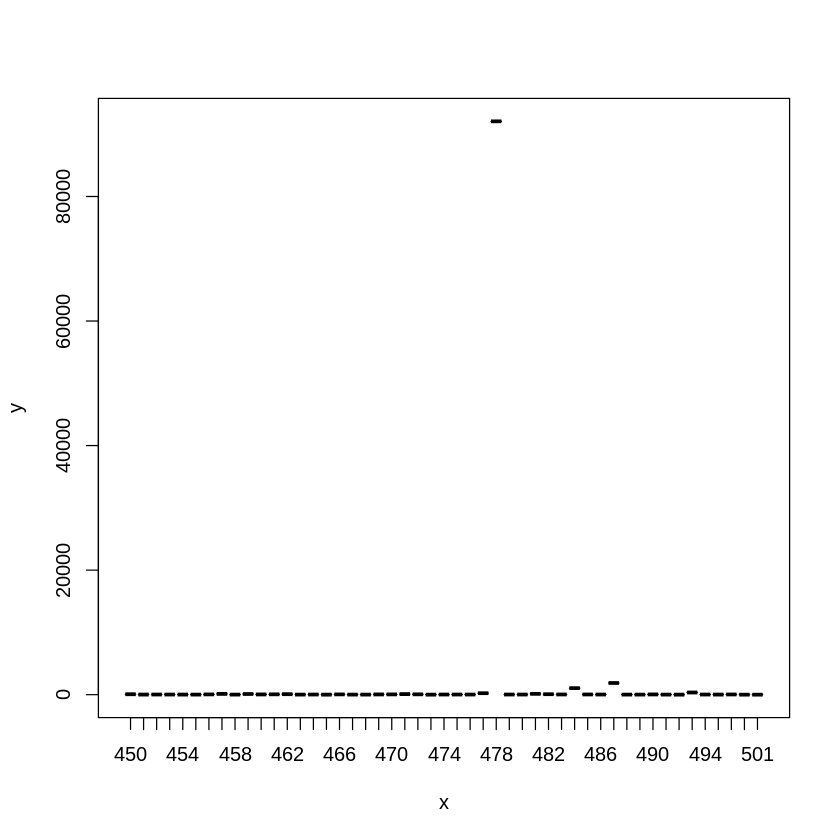

In [14]:
seqlens <- nchar(getSequences(seqtab))
seqtab.filt <- seqtab[,seqlens >= 450]
dim(seqtab.filt)
# get histogram of length distribution after filter
length.histogram <- as.data.frame(table(nchar(getSequences(seqtab.filt))))
len.plt <- plot(x=length.histogram[,1], y=length.histogram[,2])
pdf(paste(wdpath, "img/", "length_hist.pdf", sep=""))
plot(x=length.histogram[,1], y=length.histogram[,2])
dev.off()

### 15. Remove chimeric sequences

In [15]:
seqtab.nochim <- removeBimeraDenovo(seqtab.filt, method="pooled", multithread=T, verbose=T)
dim(seqtab.nochim)
sum(seqtab.nochim)/sum(seqtab.filt)

Identified 58854 bimeras out of 97106 input sequences.



[1]  2251 38252

[1] 0.9135932

### 16. Processing summary

In [16]:
getN <- function(x) sum(getUniques(x))
track <- cbind(out, sapply(dadaFs, getN), sapply(dadaRs, getN), sapply(mergers, getN), rowSums(seqtab.nochim))
colnames(track) <- c("input", "filtered", "denoisedF", "denoisedR", "merged", "nochimeras")
rownames(track) <- sample.names
track
# write to file
write.table(data.frame("row_names"=rownames(track),track),"read_retention.txt", row.names=FALSE, quote=F, sep="\t")
uniquesToFasta(seqtab.nochim, "rep_set.fa")
# fix ASV names 
system("awk '/^>/{print \">ASV\" ++i; next}{print}' < rep_set.fa > rep_set_fix.fa")
system("mv rep_set_fix.fa rep_set.fa")
# write sequence table to file, fix ASV names
my_otu_table <- t(as.data.frame(seqtab.nochim)) 
ASV.seq <- as.character(unclass(row.names(my_otu_table))) 
ASV.num <- paste0("ASV", seq(ASV.seq), sep='') 
colnames(seqtab.nochim) <- ASV.num 
write.table(data.frame("row_names"=rownames(seqtab.nochim),seqtab.nochim),"sequence_table.merged.txt", row.names=FALSE, quote=F, sep="\t")

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.

Duplicate sequences detected and merged.



,input,filtered,denoisedF,denoisedR,merged,nochimeras
DM00001V1PQ,15200,14784,14474,14418,14120,12763
DM00001V2PQ16,45005,43107,42699,42714,41636,37640
DM00001V3PQ46,1141,1068,994,1001,811,542
DM00002V1PQ,5387,5247,5118,5077,4899,4503
DM00003V3PQ16,31773,30528,30203,30035,29434,26448
DM00003V3PQ55,19333,18559,18336,18256,17756,15840
DM00004V1PQ55,925,894,832,789,752,707
DM00004V1PQ65,20,19,2,19,0,0
DM00004V3PQ16,24775,23168,22939,22847,22527,21425
DM00005V1PQ36-1,5976,5772,5601,5563,5360,4961
